## CNN

### Phần A1: Huấn luyện tập Chars74K với CNN

1. Cài đặt và import các thư viện cần thiết

In [1]:
import shutil
import os
import string, re
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import cv2
import random

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Input

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

2. Tải và giải nén dữ liệu

In [2]:
import tarfile
import urllib.request

url = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz'
output_path = 'EnglishImg.tgz'

urllib.request.urlretrieve(url, output_path)

with tarfile.open(output_path, 'r:gz') as tar:
    tar.extractall('dataset')

3. Tải tên tệp và chia tập dữ liệu

In [3]:
CLASSES = string.digits + string.ascii_uppercase + string.ascii_lowercase

def load_filenames(datapath, filters=[]):
    filenames = []
    for path, dirs, files in os.walk(datapath):
        if sum(map(lambda f: f in path, filters)) == len(filters):
            filenames += list(map(lambda f: path + '/' + f, files))
    return filenames

def split_dataset(filenames, train_ratio=0.8, val_ratio=0.1):
    np.random.shuffle(filenames)
    train_size = int(len(filenames) * train_ratio)
    val_size = int(len(filenames) * val_ratio)

    train_files = filenames[:train_size]
    val_files = filenames[train_size:train_size + val_size]
    test_files = filenames[train_size + val_size:]

    return train_files, val_files, test_files

def save_filenames_to_file(filenames, filename):
    with open(filename, 'w') as f:
        for file in filenames:
            f.write(file + '\n')

def load_filenames_from_file(filename):
    with open(filename, 'r') as f:
        return [line.strip() for line in f]

def check_class_consistency(filenames):
    classes = set([os.path.basename(os.path.dirname(f)) for f in filenames])
    return len(classes) == len(CLASSES), classes

In [4]:
# Kiểm tra tính nhất quán của dữ liệu

filenames = load_filenames('dataset/English/', ['GoodImg', 'Bmp'])
train_files, val_files, test_files = split_dataset(filenames)

save_filenames_to_file(train_files, 'Split_train')
save_filenames_to_file(val_files, 'Split_val')
save_filenames_to_file(test_files, 'Split_test')

train_files = load_filenames_from_file('Split_train')
val_files = load_filenames_from_file('Split_val')
test_files = load_filenames_from_file('Split_test')

train_check, train_classes = check_class_consistency(train_files)
val_check, val_classes = check_class_consistency(val_files)
test_check, test_classes = check_class_consistency(test_files)

if not (train_check and val_check and test_check):
    print("Some datasets are missing classes. Re-distributing data.")
    # Combine all files and re-split until each dataset contains all classes
    all_files = train_files + val_files + test_files
    while not (train_check and val_check and test_check):
        train_files, val_files, test_files = split_dataset(all_files)
        train_check, train_classes = check_class_consistency(train_files)
        val_check, val_classes = check_class_consistency(val_files)
        test_check, test_classes = check_class_consistency(test_files)
    save_filenames_to_file(train_files, 'Split_train')
    save_filenames_to_file(val_files, 'Split_val')
    save_filenames_to_file(test_files, 'Split_test')

Some datasets are missing classes. Re-distributing data.


4. Sao chép các tệp vào file train, test, valid

In [5]:
train_path = "data/train"
val_path = "data/val"
test_path = "data/test"

def copy_files(file_list, dest_dir):
    for filepath in file_list:
        splits = filepath.split('/')
        category = splits[-2]
        filename = splits[-1]
        dest_category_dir = os.path.join(dest_dir, category)
        if not os.path.exists(dest_category_dir):
            os.makedirs(dest_category_dir)
        shutil.copyfile(filepath, os.path.join(dest_category_dir, filename))

with open('Split_train', 'r') as fp:
    train_files = [line.strip() for line in fp]
    copy_files(train_files, train_path)

with open('Split_val', 'r') as fp:
    val_files = [line.strip() for line in fp]
    copy_files(val_files, val_path)

with open('Split_test', 'r') as fp:
    test_files = [line.strip() for line in fp]
    copy_files(test_files, test_path)

5. Chuẩn bị generator

In [6]:
img_width = 32
img_height = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

Found 6164 images belonging to 62 classes.
Found 770 images belonging to 62 classes.
Found 771 images belonging to 62 classes.


6. Tạo và biên dịch mô hình CNN thuần với các lớp Fully-Connected

In [7]:
# Định nghĩa kích thước ảnh đầu vào
img_width, img_height = 32, 32  # Điều chỉnh kích thước phù hợp với ảnh văn bản của bạn

# Định nghĩa mô hình CNN
model = Sequential()

# Sử dụng lớp Input để xác định đầu vào của mô hình
model.add(Input(shape=(img_height, img_width, 3)))

# Thêm các lớp convolutional
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten để chuyển đổi từ tensor sang vector
model.add(Flatten())

# Thêm các lớp fully-connected
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Lớp output với 62 đầu ra tương ứng với 62 lớp
model.add(Dense(62))
model.add(Activation('softmax'))

# Hiển thị tóm tắt mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 62)                  │           7,998 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 62)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 196,670 (768.24 KB)

 Trainable params: 196,094 (765.99 KB)

 Non-trainable params: 576 (2.25 KB)

7. Huấn luyện mô hình

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/cnn_best_weights.keras",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))  # Đảm bảo trả về giá trị float

lr_callback = LearningRateScheduler(lr_scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.00001)
callbacks = [checkpointer, lr_callback, reduce_lr]
initial_lr = lr_scheduler(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Tính toán steps_per_epoch và validation_steps
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples

steps_per_epoch = num_train_samples // train_generator.batch_size
validation_steps = num_val_samples // val_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# sử dụng tf.data.Dataset và .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),  # Sửa lại số kênh màu ở đây
        tf.TensorSpec(shape=(None, 62), dtype=tf.float32)  # Số lớp đầu ra
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),  # Sửa lại số kênh màu ở đây
        tf.TensorSpec(shape=(None, 62), dtype=tf.float32)  # Số lớp đầu ra
    )
).repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

Steps per epoch: 385
Validation steps: 48


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0709 - loss: 4.1511
Epoch 1: val_accuracy improved from -inf to 0.27403, saving model to /content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/cnn_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.0712 - loss: 4.1493 - val_accuracy: 0.2740 - val_loss: 3.0081 - learning_rate: 0.0010
Epoch 2/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2724 - loss: 3.0207
Epoch 2: val_accuracy improved from 0.27403 to 0.44156, saving model to /content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/cnn_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.2725 - loss: 3.0198 - val_accuracy: 0.4416 - val_loss: 2.1763 - learning_rate: 0.0010
Epoch 3/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3676 - loss: 2.5088
Epoch 3: val_accuracy improved from 0.44156 to 0.53117, saving model to /content/drive/MyDrive/Colab_Notebooks/da/

In [ ]:
# Đánh giá và lưu mô hình
loss, acc = model.evaluate(train_generator, steps=len(train_generator))
print("Summary of constructed CNN performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print("Summary of constructed CNN performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

# Lưu mô hình hoàn chỉnh theo định dạng mới
model.save("/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_CNN.keras")
print("Saved full model to disk in new Keras format")

  3/386 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8507 - loss: 0.6085

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/386 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.7873 - loss: 0.6978
Summary of constructed CNN performance on Train Data:
 Loss = 0.7023318409919739, Accuracy = 0.7830954194068909 
--------------------
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7955 - loss: 0.7186
Summary of constructed CNN performance on Test Data:
 Loss = 0.6697952747344971, Accuracy = 0.8054474592208862 
--------------------
Saved full model to disk in new Keras format


9. Biểu đồ Loss và Accuracy

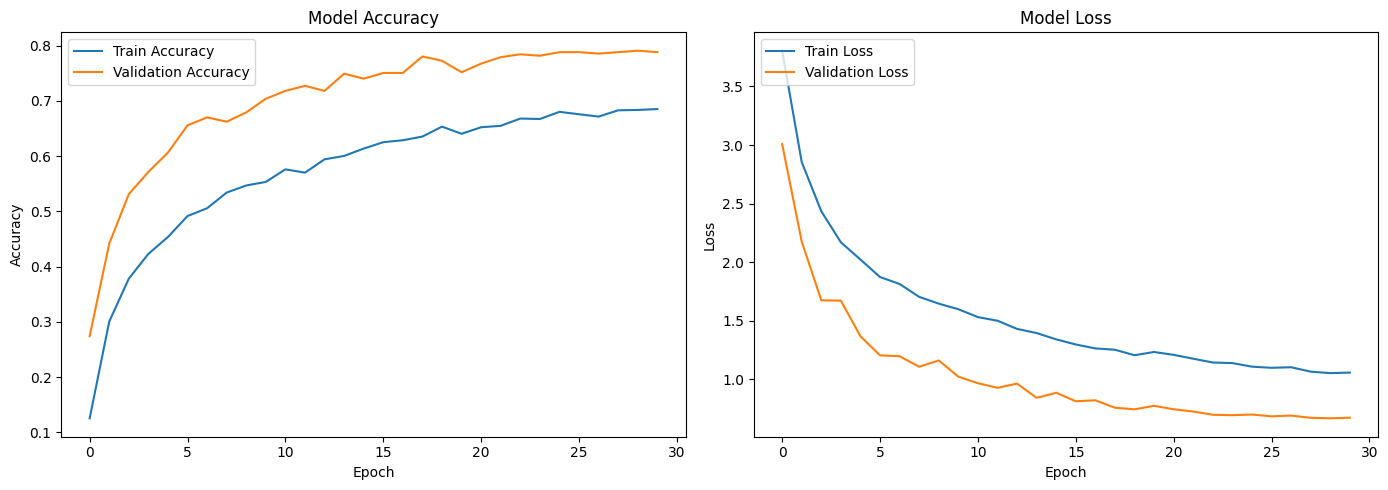

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure và các subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ biểu đồ độ chính xác
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Vẽ biểu đồ loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### Phần A2: Tính độ chính xác của mô hình trên từng ảnh ngẫu nhiên trong tập test IIIT5K - Nhận dạng văn bản trong ảnh kèm bounding box

1. Unzip file IIIT5K_coco

In [ ]:
# Đường dẫn tới tập tin zip
zip_file_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/IIIT5K_coco.zip'

# Đường dẫn tới thư mục giải nén
extract_path = '/content'

# Giải nén tập tin zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

2. Nhận dạng văn bản

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_CNN.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path, compile=False)  # Bỏ qua bộ tối ưu hóa

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/images/test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/labels/test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

Predicted: OaieSnS


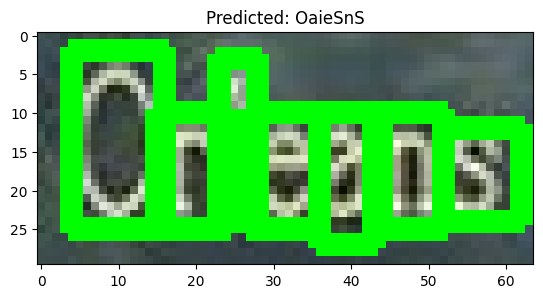

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Lấy ngẫu nhiên 1 ảnh
random_image = random.choice(list(labels.keys()))

# Đường dẫn để lưu kết quả nhận dạng
output_file_path = "recognized_texts.txt"
output_file = open(output_file_path, "w")

# Hàm để thực hiện dự đoán
def predict_character(char_img):
    prediction = model(char_img, training=False)  # Thay đổi cách gọi model.predict
    predicted_label = np.argmax(prediction)
    return predicted_label

# Lặp qua ảnh ngẫu nhiên và nhãn tương ứng
img_file = random_image
img_path = os.path.join(iiit5k_images_test_path, img_file)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    char_img = np.stack((char_img,) * 3, axis=-1)  # Chuyển từ grayscale thành RGB
    char_img = char_img.reshape(1, 32, 32, 3)
    char_img = char_img / 255.0

    # Dự đoán ký tự
    predicted_label = predict_character(char_img)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")
output_file.write(f"Predicted: {recognized_text}\n")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.show()

output_file.close()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 33.33%


In [ ]:
# Tải xuống
from google.colab import files
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Phần A3: Tính độ chính xác của mô hình trên tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_CNN.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path)

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/images/test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/labels/test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

# Hàm để thực hiện dự đoán
def predict_character(char_imgs):
    predictions = model.predict(char_imgs)  # Dự đoán theo batch
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

predicted_texts = []
actual_texts = []

# Dự đoán cho từng ảnh trong tập dữ liệu test
for img_file in labels.keys():
    img_path = os.path.join(iiit5k_images_test_path, img_file)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    recognized_text = ""
    actual_text = ""

    char_imgs = []
    class_ids = []

    for label in labels[img_file]:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = gray.shape
        x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
        x, y = int(x_center - width / 2), int(y_center - height / 2)
        w, h = int(width), int(height)

        # Cắt ký tự từ ảnh
        char_img = gray[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (32, 32))
        char_img = np.stack((char_img,) * 3, axis=-1)
        char_img = char_img / 255.0

        char_imgs.append(char_img)
        class_ids.append(int(class_id))

    char_imgs = np.array(char_imgs)  # Kết hợp các ảnh ký tự thành một mảng duy nhất
    char_imgs = char_imgs.reshape(-1, 32, 32, 3)  # Đảm bảo hình dạng đúng

    predicted_labels = predict_character(char_imgs)

    for predicted_label in predicted_labels:
        recognized_text += CLASSES[predicted_label]
    for class_id in class_ids:
        actual_text += CLASSES[class_id]

    # Lưu kết quả nhận dạng và nhãn thực tế
    predicted_texts.append(recognized_text)
    actual_texts.append(actual_text)

# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy on IIIT5K test dataset: {accuracy * 100:.2f}%")

Accuracy on IIIT5K test dataset: 61.68%


## DENSENET121

### Phần B1: Huấn luyện Chars74K với DenseNet121

1. Chuẩn bị generator với ảnh RGB

In [ ]:
# Sử dụng ImageDataGenerator với các kỹ thuật tăng cường dữ liệu khác
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    color_mode='rgb',  # Đảm bảo sử dụng ảnh màu
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

Found 6164 images belonging to 62 classes.
Found 770 images belonging to 62 classes.
Found 771 images belonging to 62 classes.


2. Tạo và biên dịch mô hình CNN với DenseNet121

In [8]:
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD

# Load DenseNet121 pre-trained model + higher level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

# Defining the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,150,654 (31.09 MB)

 Trainable params: 1,113,150 (4.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

3. Huấn luyện mô hình

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/densenet_best_weights.keras",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))  # Đảm bảo trả về giá trị float

lr_callback = LearningRateScheduler(lr_scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.00001)
callbacks = [checkpointer, lr_callback, reduce_lr]
initial_lr = lr_scheduler(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Tính toán steps_per_epoch và validation_steps
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples

steps_per_epoch = num_train_samples // train_generator.batch_size
validation_steps = num_val_samples // val_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# sử dụng tf.data.Dataset và .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),  # Sửa lại số kênh màu ở đây
        tf.TensorSpec(shape=(None, 62), dtype=tf.float32)  # Số lớp đầu ra
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),  # Sửa lại số kênh màu ở đây
        tf.TensorSpec(shape=(None, 62), dtype=tf.float32)  # Số lớp đầu ra
    )
).repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

Steps per epoch: 385
Validation steps: 48


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2252 - loss: 3.3696
Epoch 1: val_accuracy improved from -inf to 0.44805, saving model to /content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/densenet_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - accuracy: 0.2254 - loss: 3.3683 - val_accuracy: 0.4481 - val_loss: 2.1145 - learning_rate: 0.0010
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3824 - loss: 2.2967
Epoch 2: val_accuracy improved from 0.44805 to 0.50779, saving model to /content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/densenet_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.3824 - loss: 2.2965 - val_accuracy: 0.5078 - val_loss: 1.8237 - learning_rate: 0.0010
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4436 - loss: 1.9953
Epoch 3: val_accuracy improved from 0.50779 to 0.51429, saving model to /content/drive/MyDrive/Cola

4. Đánh giá và lưu mô hình

In [ ]:
# Đánh giá và lưu mô hình
loss, acc = model.evaluate(train_generator, steps=len(train_generator))
print("Summary of constructed DenseNet121 performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print("Summary of constructed DenseNet121 performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

# Lưu mô hình hoàn chỉnh theo định dạng mới
model.save("/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_densenet.keras")
print("Saved full model to disk in new Keras format")

386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.8083 - loss: 0.6560
Summary of constructed DenseNet121 performance on Train Data:
 Loss = 0.6552910804748535, Accuracy = 0.804347813129425 
--------------------
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6485 - loss: 1.2972
Summary of constructed DenseNet121 performance on Test Data:
 Loss = 1.1853492259979248, Accuracy = 0.6822308897972107 
--------------------
Saved full model to disk in new Keras format


5. Biểu đồ Loss và Accuracy

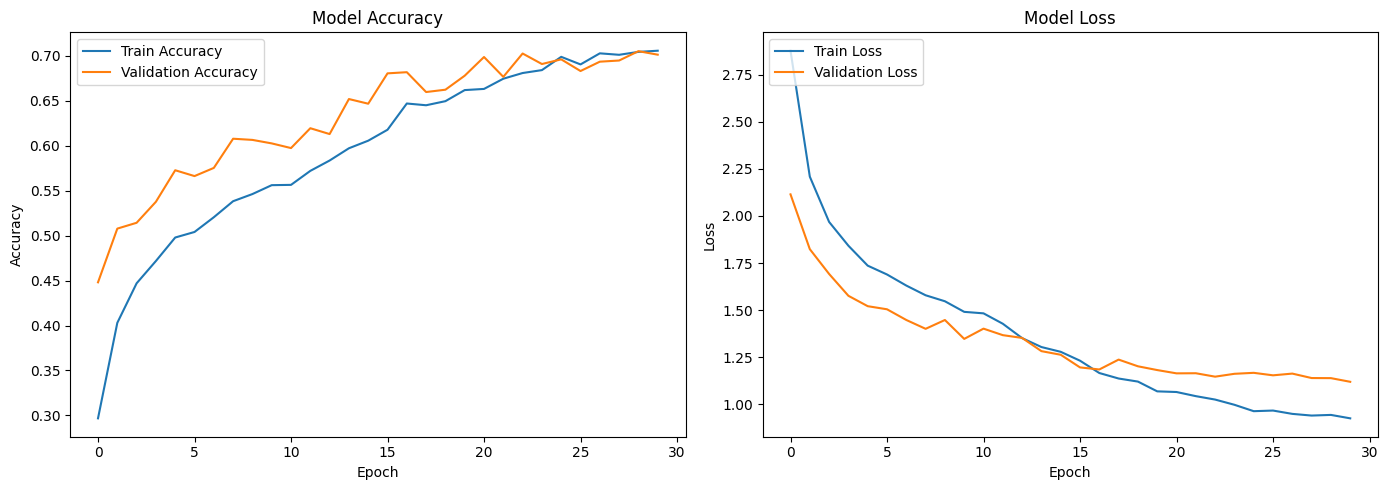

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure và các subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ biểu đồ độ chính xác
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Vẽ biểu đồ loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### Phần B2: Tính độ chính xác của mô hình trên từng ảnh ngẫu nhiên trong tập test IIIT5K - Nhận dạng văn bản trong ảnh kèm bounding box

1. Đoạn mã tính độ chính xác

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_densenet.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path, compile=False)  # Bỏ qua bộ tối ưu hóa

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/images/test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/labels/test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

Predicted: RRV


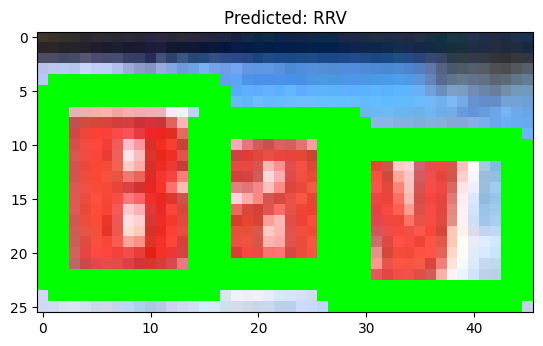

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Lấy ngẫu nhiên 1 ảnh
random_image = random.choice(list(labels.keys()))

# Đường dẫn để lưu kết quả nhận dạng
output_file_path = "recognized_texts.txt"
output_file = open(output_file_path, "w")

# Hàm để thực hiện dự đoán
def predict_character(char_img):
    prediction = model(char_img, training=False)  # Thay đổi cách gọi model.predict
    predicted_label = np.argmax(prediction)
    return predicted_label

# Lặp qua ảnh ngẫu nhiên và nhãn tương ứng
img_file = random_image
img_path = os.path.join(iiit5k_images_test_path, img_file)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    char_img = np.stack((char_img,) * 3, axis=-1)  # Chuyển từ grayscale thành RGB
    char_img = char_img.reshape(1, 32, 32, 3)
    char_img = char_img / 255.0

    # Dự đoán ký tự
    predicted_label = predict_character(char_img)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")
output_file.write(f"Predicted: {recognized_text}\n")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.show()

output_file.close()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 0.00%


In [ ]:
# Tải xuống
from google.colab import files
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Phần B3: Tính độ chính xác của mô hình trên tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_densenet.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path)

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/images/test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/labels/test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

# Hàm để thực hiện dự đoán
def predict_character(char_imgs):
    predictions = model.predict(char_imgs)  # Dự đoán theo batch
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

predicted_texts = []
actual_texts = []

# Dự đoán cho từng ảnh trong tập dữ liệu test
for img_file in labels.keys():
    img_path = os.path.join(iiit5k_images_test_path, img_file)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    recognized_text = ""
    actual_text = ""

    char_imgs = []
    class_ids = []

    for label in labels[img_file]:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = gray.shape
        x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
        x, y = int(x_center - width / 2), int(y_center - height / 2)
        w, h = int(width), int(height)

        # Cắt ký tự từ ảnh
        char_img = gray[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (32, 32))
        char_img = np.stack((char_img,) * 3, axis=-1)
        char_img = char_img / 255.0

        char_imgs.append(char_img)
        class_ids.append(int(class_id))

    char_imgs = np.array(char_imgs)  # Kết hợp các ảnh ký tự thành một mảng duy nhất
    char_imgs = char_imgs.reshape(-1, 32, 32, 3)  # Đảm bảo hình dạng đúng

    predicted_labels = predict_character(char_imgs)

    for predicted_label in predicted_labels:
        recognized_text += CLASSES[predicted_label]
    for class_id in class_ids:
        actual_text += CLASSES[class_id]

    # Lưu kết quả nhận dạng và nhãn thực tế
    predicted_texts.append(recognized_text)
    actual_texts.append(actual_text)

# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 45.52%


## VGG19

### Phần C1: Huấn luyện Chars74K với VGG19

1. Chuẩn bị generator với ảnh RGB

In [ ]:
# Sử dụng ImageDataGenerator với các kỹ thuật tăng cường dữ liệu khác
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_width, img_height),
    color_mode='rgb',  # Đảm bảo sử dụng ảnh màu
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical'
)

Found 6164 images belonging to 62 classes.
Found 770 images belonging to 62 classes.
Found 771 images belonging to 62 classes.


2. Tạo và biên dịch mô hình CNN với VGG19

In [ ]:
from keras.applications import VGG19

# Load VGG19 pre-trained model + higher level layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

# Defining the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,613,246 (78.63 MB)

 Trainable params: 588,862 (2.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

3. Huấn luyện mô hình

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/vgg19_best_weights.keras",
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return float(0.001 * tf.math.exp(0.1 * (10 - epoch)))  # Đảm bảo trả về giá trị float

lr_callback = LearningRateScheduler(lr_scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=0.00001)
callbacks = [checkpointer, lr_callback, reduce_lr]
initial_lr = lr_scheduler(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Tính toán steps_per_epoch và validation_steps
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples

steps_per_epoch = num_train_samples // train_generator.batch_size
validation_steps = num_val_samples // val_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# sử dụng tf.data.Dataset và .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),  # Sửa lại số kênh màu ở đây
        tf.TensorSpec(shape=(None, 62), dtype=tf.float32)  # Số lớp đầu ra
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),  # Sửa lại số kênh màu ở đây
        tf.TensorSpec(shape=(None, 62), dtype=tf.float32)  # Số lớp đầu ra
    )
).repeat()

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

Steps per epoch: 385
Validation steps: 48


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2442 - loss: 3.1002
Epoch 1: val_accuracy improved from -inf to 0.45065, saving model to /content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/vgg19_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.2444 - loss: 3.0992 - val_accuracy: 0.4506 - val_loss: 1.9768 - learning_rate: 0.0010
Epoch 2/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4146 - loss: 2.1372
Epoch 2: val_accuracy improved from 0.45065 to 0.52468, saving model to /content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/vgg19_best_weights.keras
386/386 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.4147 - loss: 2.1369 - val_accuracy: 0.5247 - val_loss: 1.7127 - learning_rate: 0.0010
Epoch 3/30
385/386 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4711 - loss: 1.8898
Epoch 3: val_accuracy did not improve from 0.52468
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.47

4. Đánh giá và lưu mô hình

In [ ]:
# Đánh giá và lưu mô hình
loss, acc = model.evaluate(train_generator, steps=len(train_generator))
print("Summary of constructed VGG19 performance on Train Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print("Summary of constructed VGG19 performance on Test Data:\n Loss = {}, Accuracy = {} ".format(loss, acc))
print('-'*20)

# Lưu mô hình hoàn chỉnh theo định dạng mới
model.save("/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_vgg19.keras")
print("Saved full model to disk in new Keras format")

386/386 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.7820 - loss: 0.7126
Summary of constructed VGG19 performance on Train Data:
 Loss = 0.6874369978904724, Accuracy = 0.7921804189682007 
--------------------
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6650 - loss: 1.2123
Summary of constructed VGG19 performance on Test Data:
 Loss = 1.1777969598770142, Accuracy = 0.6692606806755066 
--------------------
Saved full model to disk in new Keras format


5. Biểu đồ Loss và Accuracy

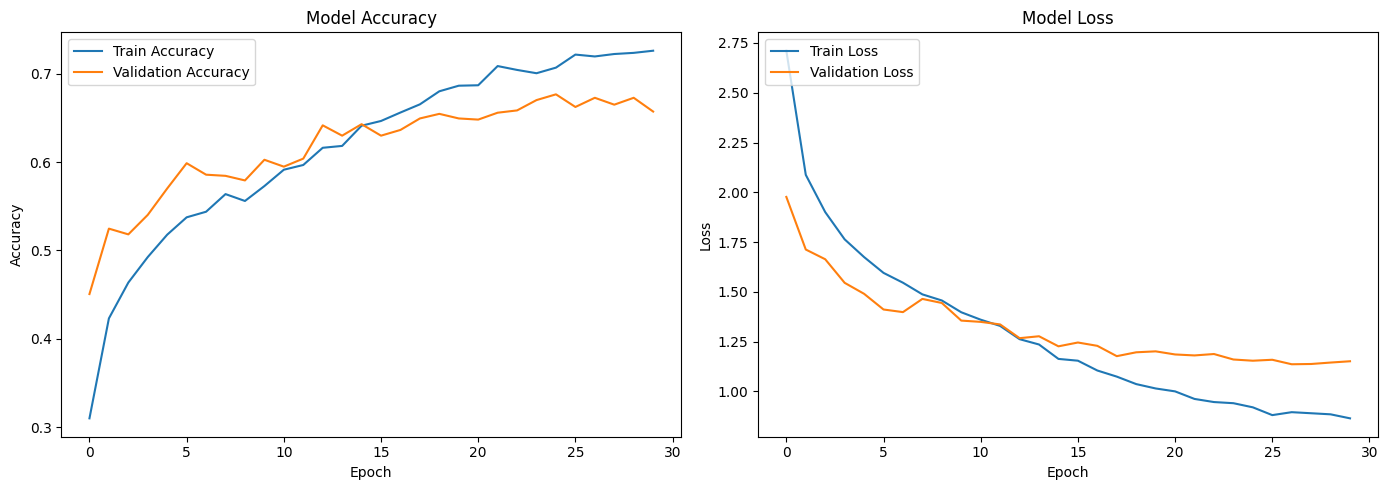

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure và các subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vẽ biểu đồ độ chính xác
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Vẽ biểu đồ loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### Phần C2: Tính độ chính xác của mô hình trên từng ảnh ngẫu nhiên trong tập test IIIT5K - Nhận dạng văn bản trong ảnh kèm bounding box

1. Đoạn mã tính độ chính xác

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_vgg19.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path, compile=False)  # Bỏ qua bộ tối ưu hóa

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/images/test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/labels/test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

Predicted: IOOyy


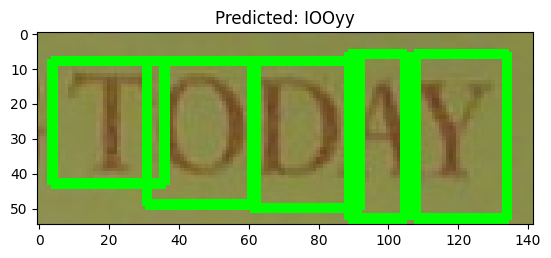

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

predicted_texts = []
actual_texts = []

# Lấy ngẫu nhiên 1 ảnh
random_image = random.choice(list(labels.keys()))

# Đường dẫn để lưu kết quả nhận dạng
output_file_path = "recognized_texts.txt"
output_file = open(output_file_path, "w")

# Hàm để thực hiện dự đoán
def predict_character(char_img):
    prediction = model(char_img, training=False)  # Thay đổi cách gọi model.predict
    predicted_label = np.argmax(prediction)
    return predicted_label

# Lặp qua ảnh ngẫu nhiên và nhãn tương ứng
img_file = random_image
img_path = os.path.join(iiit5k_images_test_path, img_file)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

recognized_text = ""

for label in labels[img_file]:
    class_id, x_center, y_center, width, height = map(float, label.split())

    # Chuyển đổi tọa độ YOLO sang tọa độ ảnh
    img_h, img_w = gray.shape
    x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
    x, y = int(x_center - width / 2), int(y_center - height / 2)
    w, h = int(width), int(height)

    # Cắt ký tự từ ảnh
    char_img = gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (32, 32))
    char_img = np.stack((char_img,) * 3, axis=-1)  # Chuyển từ grayscale thành RGB
    char_img = char_img.reshape(1, 32, 32, 3)
    char_img = char_img / 255.0

    # Dự đoán ký tự
    predicted_label = predict_character(char_img)
    recognized_text += CLASSES[int(predicted_label)]

    # Vẽ bounding box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Lưu kết quả nhận dạng và nhãn thực tế
predicted_texts.append(recognized_text)
actual_texts.append("".join([CLASSES[int(label.split()[0])] for label in labels[img_file]]))

# In ra kết quả nhận dạng
print(f"Predicted: {recognized_text}")
output_file.write(f"Predicted: {recognized_text}\n")

# Hiển thị ảnh với bounding box
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {recognized_text}")
plt.show()

output_file.close()

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 20.00%


In [ ]:
# Tải xuống
from google.colab import files
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Phần C3: Tính độ chính xác của mô hình trên tập dữ liệu IIIT5K

In [ ]:
# Đường dẫn đến mô hình đã được huấn luyện
model_path = '/content/drive/MyDrive/Colab_Notebooks/da/KLTN_Final_3/Model_Checkpoint_RGB/model_full_vgg19.keras'  # Cập nhật đường dẫn nếu cần
model = load_model(model_path)

# Đường dẫn đến tập dữ liệu IIIT5K
iiit5k_images_test_path = '/content/images/test'  # Cập nhật đường dẫn
iiit5k_labels_test_path = '/content/labels/test'  # Cập nhật đường dẫn

# Hàm để đọc nhãn từ file
def read_labels(filepath):
    labels = {}
    for label_file in os.listdir(filepath):
        with open(os.path.join(filepath, label_file), 'r') as file:
            labels[label_file.replace('.txt', '.jpg')] = file.readlines()
    return labels

labels = read_labels(iiit5k_labels_test_path)

In [ ]:
# Hàm để tính độ chính xác
def calculate_accuracy(predicted_texts, actual_texts):
    correct_chars = 0
    total_chars = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        correct_chars += sum(p == a for p, a in zip(predicted, actual))
        total_chars += len(actual)

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy

# Hàm để thực hiện dự đoán
def predict_character(char_imgs):
    predictions = model.predict(char_imgs)  # Dự đoán theo batch
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

predicted_texts = []
actual_texts = []

# Dự đoán cho từng ảnh trong tập dữ liệu test
for img_file in labels.keys():
    img_path = os.path.join(iiit5k_images_test_path, img_file)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    recognized_text = ""
    actual_text = ""

    char_imgs = []
    class_ids = []

    for label in labels[img_file]:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = gray.shape
        x_center, y_center, width, height = x_center * img_w, y_center * img_h, width * img_w, height * img_h
        x, y = int(x_center - width / 2), int(y_center - height / 2)
        w, h = int(width), int(height)

        # Cắt ký tự từ ảnh
        char_img = gray[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (32, 32))
        char_img = np.stack((char_img,) * 3, axis=-1)
        char_img = char_img / 255.0

        char_imgs.append(char_img)
        class_ids.append(int(class_id))

    char_imgs = np.array(char_imgs)  # Kết hợp các ảnh ký tự thành một mảng duy nhất
    char_imgs = char_imgs.reshape(-1, 32, 32, 3)  # Đảm bảo hình dạng đúng

    predicted_labels = predict_character(char_imgs)

    for predicted_label in predicted_labels:
        recognized_text += CLASSES[predicted_label]
    for class_id in class_ids:
        actual_text += CLASSES[class_id]

    # Lưu kết quả nhận dạng và nhãn thực tế
    predicted_texts.append(recognized_text)
    actual_texts.append(actual_text)

# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━

In [ ]:
# Tính toán độ chính xác
accuracy = calculate_accuracy(predicted_texts, actual_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 41.53%
